# Simulate Diffuse Maps for Albatros

Spherical harmonics are the natural basis for imaging on a sphere. This notebook is an attempt to understand m-mode imaging and the various factors involved in interferometry on a sphere.

In particular I'm trying to take a healpix map of diffuse flux and use spherical harmonics to image it with an interferometer instead of treating each pixel of the map as a discrete point source

### Spherical Harmonic Transform of the Sky and Beam

- Suppose you have a sky map $I(\theta, \phi)$ and a beam pattern $B(\theta, \phi)$
- Both can be decomposed into spherical harmonics $Y_{lm}(\theta, \phi):$

$$I(\theta, \phi) = \sum_{lm}a^{sky}_{lm}Y_{lm}(\theta, \phi),$$

$$B(\theta, \phi) = \sum_{lm}a^{beam}_{lm}Y_{lm}(\theta, \phi),$$

where $a^{sky}_{lm}$, $a^{beam}_{lm}$ are the spherical harmonic coefficients of the sky and the beam respectively

### Compute Visibilities

Visibilities are weighted integrals of the sky multiplied by the beam with a geometric phase term for a baseline, sampling a fourier mode on the sky

$$V_{ij} = \int I(\theta, \phi) B(\theta, \phi) e^{-2\pi i\mathbf{u}_{ij} \cdot \mathbf{s}} d\Omega$$

where, 
- $\mathbf{u}_{ij}$ is the baseline vector between antennas $i$, $j$ in wavelenghts
- $e^{-2\pi i\mathbf{u}_{ij} \cdot \mathbf{s}}$ represents the interferometer’s Fourier sampling of the sky

Since spherical harmonics are orthogonal

$$q_m = \sum_{l}a^{sky}_{lm} \cdot a^{beam}_{lm}$$

We can either think of the sky rotating over a stationary beam, or the earth scanning the beam across a starionary sky. This can be achieved by multiplying $q_m$ by a factor of $e^{im\Phi}$, where $\Phi$ is the sidereal azimuthal angle. So the visibility as a function of time (or rotation angle $\Phi$) becomes:

$$V(\Phi) = \sum_m e^{im\Phi} q_m$$

This represents the rotationally averaged visibilities

In [1]:
import numpy as np
import healpy as hp

import cmasher as cmr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS

from pyuvdata import utils
from pygdsm import GlobalSkyModel
from pyuvdata import UVData, UVBeam

from skyfield.api import load, wgs84

# beautiful colormap
import cmasher as cmr

nice_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(nice_fonts)

## Read OWRO LWA Beam model

Courtesy of Nivedita Mahesh via Ruby Byrne. I suspect this is a FEKO model, with MRO soil and a 3x3m groundscreen

In [2]:
beam_path = "../data/beams/LWA_10to100_MROsoil_efields.fits"
beam = UVBeam()
beam.read(beam_path)
beam.select(axis2_inds=np.where(beam.axis2_array <= np.pi/2)[0])
beam.peak_normalize()

hpx_ebeam = beam.to_healpix(inplace=False)
pstokes_beam = beam.efield_to_pstokes(inplace=False)
pstokes_hpx_beam = hpx_ebeam.efield_to_pstokes(inplace=False)

In [3]:
freq = 14e6
nside=1024

l_max = (3*nside)-1
n_m = (2 * l_max) + 1
sidereal = 86164.0905
d_sidereal = sidereal / n_m
albatros = EarthLocation(lat=79.417183, lon=-90.767350, height=189)
time = Time("2025-01-01 00:00:00", scale="utc", location=albatros) + TimeDelta(sidereal/2 - d_sidereal/2, format="sec")

In [25]:
n_m

np.int64(6143)

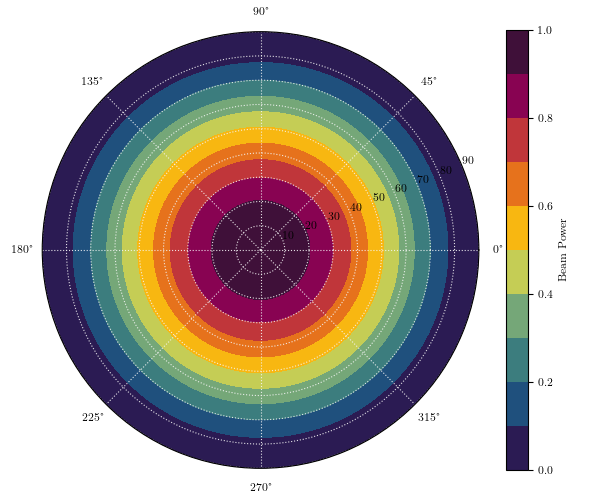

In [4]:
%matplotlib widget

pstokes_beam_freq = pstokes_beam.select(frequencies=[freq], inplace=False)

# plotting pseudo-stokes
pol_array = pstokes_beam_freq.polarization_array
pI_ind = np.where(np.isin(pol_array, utils.polstr2num('pI')))[0][0]
az_array, za_array = np.meshgrid(pstokes_beam_freq.axis1_array, np.rad2deg(pstokes_beam_freq.axis2_array))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(6, 5))
ax.grid(True, ls=":", color="whitesmoke", alpha=0.9)

contourplot = ax.contourf(
    az_array,
    za_array,
    pstokes_beam_freq.data_array[0,  pI_ind, 0],
    levels=11,
    cmap=cmr.pride,
)
cbar=plt.colorbar(contourplot, ax=ax, label="Beam Power", orientation="vertical",shrink=1)

plt.tight_layout()
plt.show() 

In [5]:
pstokes_hpx_beam_freq = pstokes_hpx_beam.select(frequencies=[freq], inplace=False)
hpx_beam = np.zeros(hp.nside2npix(pstokes_hpx_beam.nside))
hpx_beam[:pstokes_hpx_beam_freq.Npixels] += pstokes_hpx_beam_freq.data_array[0, 0, 0, :]
hpx_beam_nside = hp.pixelfunc.ud_grade(hpx_beam, nside)

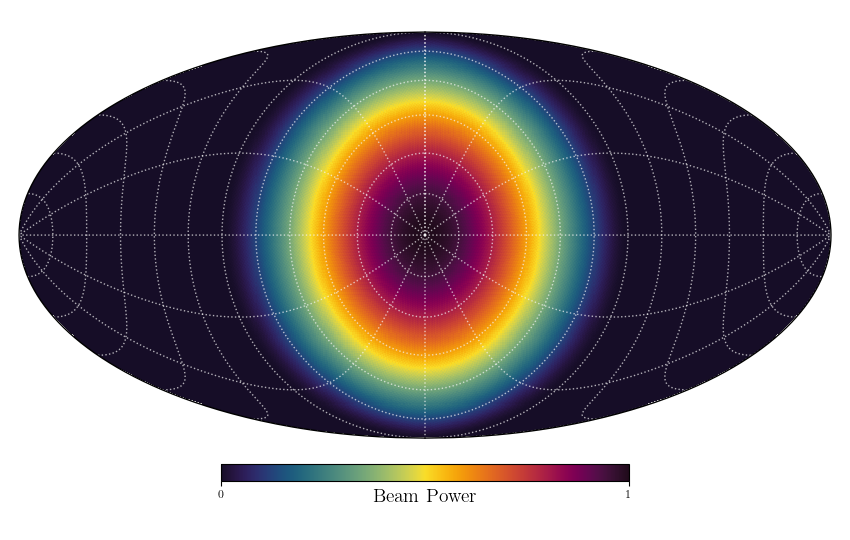

In [6]:
%matplotlib widget

# Define a colormap with 11 discrete colors
colors = cmr.pride(np.linspace(0, 1, 11))
cmap = ListedColormap(colors)

hp.mollview(
    hpx_beam_nside,
    rot=(0, 90),
    # cmap=cmap,
    cmap=cmr.pride,
    cbar=True,
    max=1,
    unit='Beam Power',
    title="")

hp.visufunc.graticule(15, 360/12, ls=":", color="whitesmoke", alpha=0.7)
plt.show()

## PyGDSM

In [7]:
gsm = GlobalSkyModel(freq_unit='MHz')
hpx_gsm = gsm.generate(freq/1e6)
hpx_gsm_nside = hp.pixelfunc.ud_grade(hpx_gsm, nside)

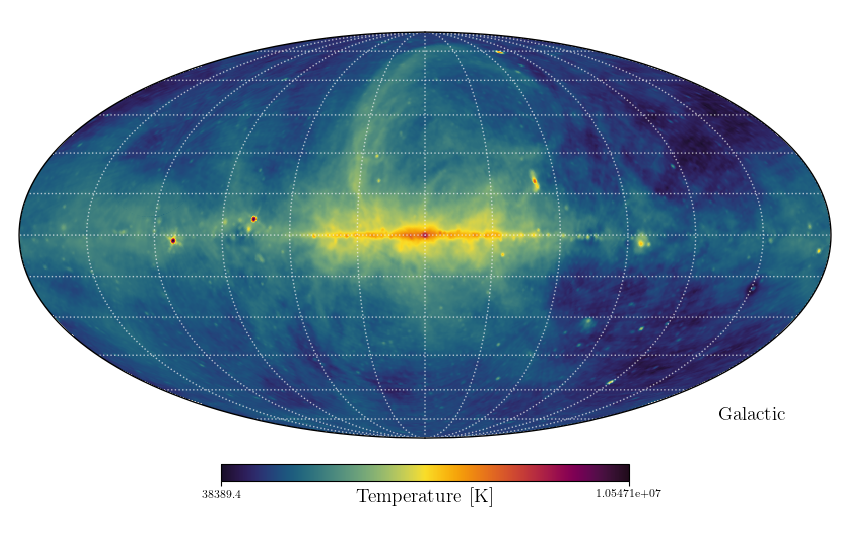

In [8]:
%matplotlib widget

hp.mollview(
    hpx_gsm_nside,
    coord="G",
    cmap=cmr.pride,
    cbar=True,
    norm="log",
    unit='Temperature [K]',
    title="")

hp.visufunc.graticule(15, 360/12, ls=":", color="whitesmoke", alpha=0.7)
plt.show()

In [9]:
def rotate_healpix_to_zenith(hp_map, observer_location, obstime):
    """
    Convert a HEALPix map from Galactic to Equatorial (RA/Dec) and rotate it
    to be centered around the zenith for an observer at a given location and time.
    
    Parameters:
    - hp_map: ndarray, HEALPix map in Galactic coordinates
    - observer_location: astropy.coordinates.EarthLocation, Observer's location on Earth
    - obstime: str or astropy.time.Time, Observation time (ISO format or astropy Time object)
    
    Returns:
    - rotated_map: ndarray, HEALPix map rotated to zenith-centered RA/Dec
    """
    # Convert observation time
    obstime = Time(obstime) if not isinstance(obstime, Time) else obstime
    
    # Define observer location using Skyfield
    ts = load.timescale()
    skyfield_time = ts.from_astropy(obstime)
    observer = wgs84.latlon(observer_location.lat.deg, observer_location.lon.deg, observer_location.height.to(u.m).value)
    
    # Compute zenith RA/Dec
    altaz_frame = AltAz(obstime=obstime, location=observer_location)
    zenith = SkyCoord(alt=90*u.deg, az=0*u.deg, frame=altaz_frame).transform_to(ICRS())
    ra_zenith, dec_zenith = zenith.ra.deg, zenith.dec.deg
    
    # Get HEALPix NSIDE from the map
    nside = hp.get_nside(hp_map)
    
    # Get Galactic coordinates from HEALPix pixel centers
    npix = hp.nside2npix(nside)
    theta_gal, phi_gal = hp.pix2ang(nside, np.arange(npix))
    galactic_coords = SkyCoord(l=phi_gal * u.rad, 
                               b=(np.pi/2 - theta_gal) * u.rad, 
                               frame='galactic')
    
    # Convert Galactic to Equatorial (ICRS)
    equatorial_coords = galactic_coords.transform_to(ICRS())
    
    # Convert RA/Dec to HEALPix indices
    theta = np.radians(90 - equatorial_coords.dec.deg)  # Colatitude
    phi = np.radians(equatorial_coords.ra.deg)  # Longitude
    pix_equatorial = hp.ang2pix(nside, theta, phi)
    
    # Rotate map to place zenith at the center
    rotator = hp.Rotator(rot=[ra_zenith, dec_zenith], coord=['C', 'G'], inv=True)
    theta_rot, phi_rot = rotator(theta, phi)
    pix_rotated = hp.ang2pix(nside, theta_rot, phi_rot)
    
    # Apply rotation
    rotated_map = hp_map[pix_rotated]
    
    return rotated_map

In [10]:
hpx_gsm_nside_rot = rotate_healpix_to_zenith(hpx_gsm_nside, albatros, time)

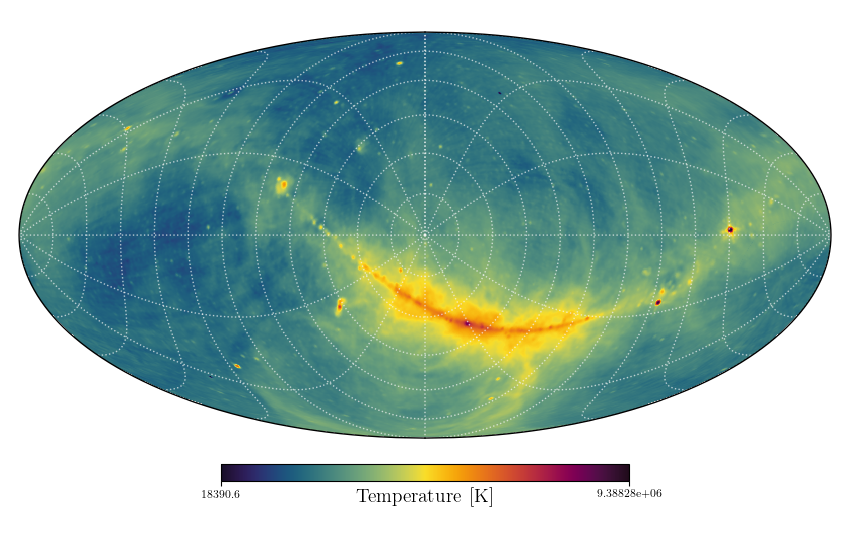

In [11]:
%matplotlib widget

hp.mollview(
    hpx_gsm_nside_rot,
    # coord="GC",
    rot=[0, 90],
    cmap=cmr.pride,
    cbar=True,
    norm="log",
    unit='Temperature [K]',
    title="")

hp.visufunc.graticule(15, 360/12, ls=":", color="whitesmoke", alpha=0.7)
plt.show()

## Albatros Baselines

In [12]:
uvd = UVData.from_file("../data/uvfits/albatros_sim_zenith_uniform_beam_4_16MHz_24h.uvfits")
uvw_meters = uvd.uvw_array[..., np.newaxis].reshape([-1, 3])
print(uvw_meters[:21])

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.74406426e+02  4.13850832e+00 -1.20816000e+01]
 [-1.19791173e+02 -1.89900762e+02 -4.99800000e+01]
 [-5.21614203e+03 -3.05013462e+03 -7.53810700e+02]
 [ 2.05009435e+03  1.27797229e+02 -1.10433600e+02]
 [-6.93231043e+02 -2.07061477e+03 -5.37244600e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.94197599e+02 -1.94039270e+02 -3.78984000e+01]
 [-5.39054846e+03 -3.05427313e+03 -7.41729100e+02]
 [ 1.87568793e+03  1.23658721e+02 -9.83520000e+01]
 [-8.67637469e+02 -2.07475327e+03 -5.25163000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.09635086e+03 -2.86023386e+03 -7.03830700e+02]
 [ 2.16988552e+03  3.17697991e+02 -6.04536000e+01]
 [-5.73439870e+02 -1.88071400e+03 -4.87264600e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.26623638e+03  3.17793185e+03  6.43377100e+02]
 [ 4.52291099e+03  9.79519853e+02  2.16566100e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.74332539e+03 -2.19841199e+

In [13]:
uvw_meters[2] / (3e8/freq)

array([-5.59025473, -8.86203554, -2.3324    ])

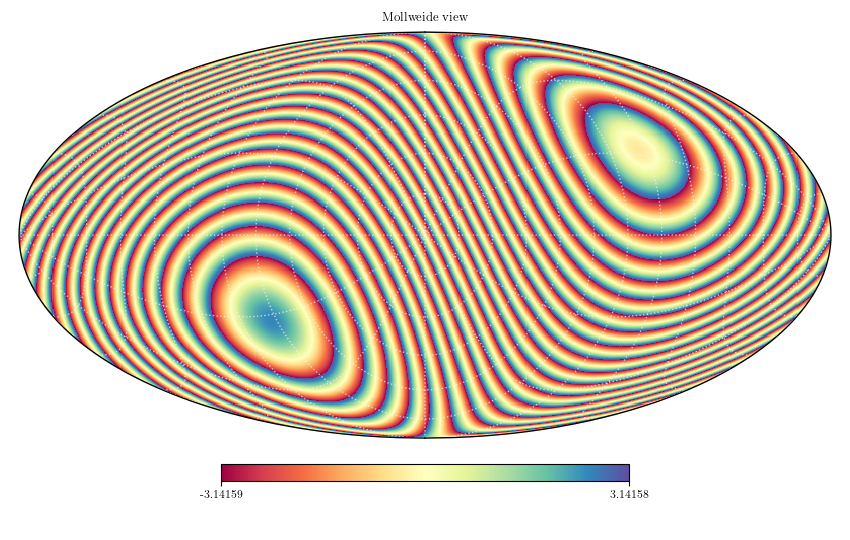

In [14]:
# Define (u, v, w) in wavelengths
# u, v, w = 10, 10, 0
u, v, w = uvw_meters[2] / (3e8/freq)

# Generate HEALPix pixel indices
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))

# Compute l, m, n
l = np.sin(theta) * np.cos(phi)
m = np.sin(theta) * np.sin(phi)
n = np.cos(theta)

# Compute Fourier Transform Kernel
phase = -2 * np.pi * (u * l + v * m + w * (n - 1))
fourier_kernel = np.exp(1j * phase)

# Plot the HEALPix map
hp.mollview(np.angle(fourier_kernel), cmap="Spectral", rot=[0, 90])
hp.visufunc.graticule(15, 360/12, ls=":", color="whitesmoke", alpha=0.7)
plt.show()

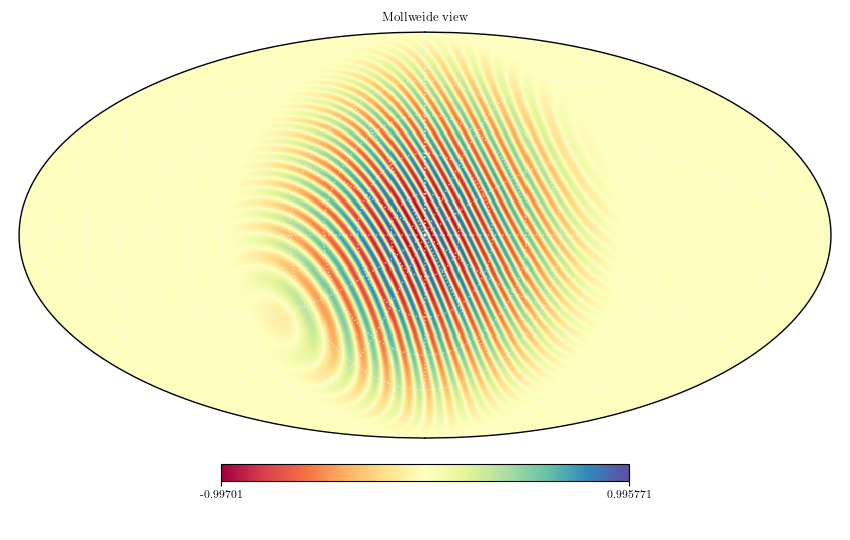

In [15]:
# Plot the HEALPix map
hp.mollview(np.real(hpx_beam_nside * fourier_kernel), cmap="Spectral", rot=[0, 90])
hp.visufunc.graticule(15, 360/12, ls=":", color="whitesmoke", alpha=0.7)
plt.show()

In [16]:
def compute_full_alm(healpix_map):
    """
    Computes the full set of spherical harmonic coefficients (a_lm) for both 
    positive and negative m-modes from a Healpix map.
    
    Healpy's map2alm function only returns coefficients for m >= 0. This function
    reconstructs a_lm for negative m-values using the symmetry relation:
    
        a_{l, -m} = (-1)^m * conj(a_{l, m})
    
    Parameters
    ----------
    healpix_map : ndarray
        A real or complex-valued Healpix map (1D array of size npix).
    
    Returns
    -------
    alm_full : ndarray
        The full set of complex spherical harmonic coefficients including 
        both positive and negative m-modes.
    
    ell_full : ndarray
        The corresponding ell values for each a_lm coefficient.
    
    m_full : ndarray
        The corresponding m values (including negative m).
    """
    
    # Compute spherical harmonic coefficients for m >= 0
    alm = hp.map2alm(healpix_map)
    
    # Determine the maximum spherical harmonic degree (lmax)
    lmax = hp.Alm.getlmax(alm.size)  # Corrected to use len(alm), not map
    
    # Retrieve ell and m indices for positive m-modes
    ell, m = hp.Alm.getlm(lmax)
    
    # Find indices where m > 0
    positive_m_indices = np.where(m > 0)[0]

    # Compute a_lm for negative m-modes using symmetry
    alm_negative = ((-1) ** m[positive_m_indices]) * np.conj(alm[positive_m_indices])

    # Combine positive and negative m-modes
    alm_full = np.concatenate([alm_negative, alm])  
    ell_full = np.concatenate([ell[positive_m_indices], ell])  
    m_full = np.concatenate([-m[positive_m_indices], m])  

    return alm_full, ell_full, m_full

In [17]:
alm_sky, ell, m = compute_full_alm(hpx_gsm_nside_rot)
alm_beam_real, ell, m = compute_full_alm((hpx_beam_nside * fourier_kernel).real)
alm_beam_imag, ell, m = compute_full_alm((hpx_beam_nside * fourier_kernel).imag)
alm_beam = alm_beam_real + 1j * alm_beam_imag

In [18]:
q_m_real = np.bincount(m - m.min(), weights=np.real(alm_sky * alm_beam))
q_m_imag = np.bincount(m - m.min(), weights=np.imag(alm_sky * alm_beam))
q_m = q_m_real + 1j * q_m_imag

In [19]:
m_uni = np.sort(np.unique(m))
n_m = m_uni[-1] - m_uni[0] + 1
d_m = m_uni[1] - m_uni[0]
phi = np.fft.fftshift(np.fft.fftfreq(n_m, d_m) * 2 * np.pi) 
d_t = np.fft.fftshift(np.fft.fftfreq(n_m, d_m) * sidereal)
time_array = time + TimeDelta(d_t, format="sec")
v_phi = np.fft.ifft(np.fft.ifftshift(q_m))

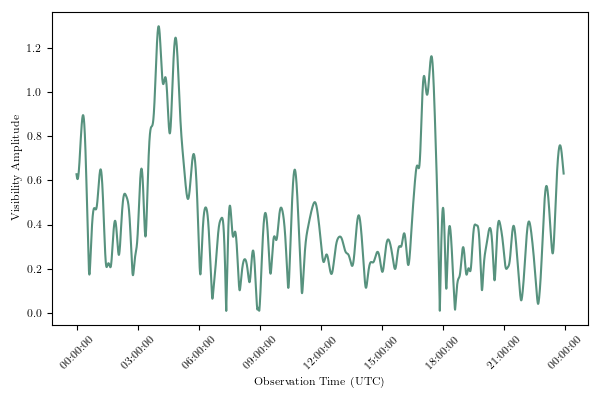

In [20]:
fig, ax = plt.subplots(figsize=[6, 4])

# ax.plot(phi/np.pi, np.abs(v_phi), color=cmr.pride(0.3))
# ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
# ax.set_xlabel(r"Sidereal Azimuthal Angle [ $\Phi$ ]")
# ax.set_ylabel("Visibility Amplitude")

ax.plot(time_array.datetime, np.abs(v_phi), color=cmr.pride(0.3))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

ax.set_xlabel("Observation Time (UTC)")
ax.set_ylabel("Visibility Amplitude")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
